In [1]:
!pip install mwclient
!pip install mwparserfromhell


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


                                              0.0/137.6 kB ? eta -:--:--
     --------                                30.7/137.6 kB 1.4 MB/s eta 0:00:01
     --------                                30.7/137.6 kB 1.4 MB/s eta 0:00:01
     --------                                30.7/137.6 kB 1.4 MB/s eta 0:00:01
     ------------------------              92.2/137.6 kB 525.1 kB/s eta 0:00:01
     ------------------------              92.2/137.6 kB 525.1 kB/s eta 0:00:01
     ------------------------------------ 137.6/137.6 kB 480.5 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for mwparserfromhell: filename=mwparserfromhell-0.6.4-cp311-cp311-win_amd64.whl size=100183 sha256=347fce5823b9afe619b1f6f28907d21fd90bf0843e0bb5c8b85b258862f8a1ad
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\ca\c5\73\7d6918569de46124b1ae60ab19d288d9becd4638d8aae8f66f
Successfully built mwparserfromhell


In [2]:
import wikipedia
import openai
import pandas as pd
import numpy as np
import re
from typing import Set
from transformers import GPT2TokenizerFast
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
import tiktoken
import mwclient
import mwparserfromhell 


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def filter_wc_2022_titles(titles):
    titles = [title for title in titles if '2022 FIFA World Cup' in title]
    return titles

def get_page(title):
    try:
        return wikipedia.page(title)
    except wikipedia.exceptions.DisambiguationError as e:
        return wikipedia.page(e.options[0])
    except wikipedia.exceptions.PageError as e:
        return None
    
def find_pages(titles, titles_so_far=set()):
    all_pages = []
    titles = list(set(titles) - titles_so_far)
    titles = filter_wc_2022_titles(titles)
    titles_so_far.update(titles)
    for title in titles:
        page = get_page(title)
        if page is None:
            continue
        all_pages.append(page)

        new_pages = find_pages(page.links, titles_so_far)
        for pg in new_pages:
            if pg.title not in [p.title for p in all_pages]:
                all_pages.append(pg)
        titles_so_far.update(page.links)
    return all_pages

pages = find_pages(['2022 FIFA World Cup'])
print(len(pages))


33


In [4]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

def count_tokens(text:str):
    return len(tokenizer.encode(text))

def reduce_long(long_text:str, long_text_tokens: bool = False, max_len: int = 590):
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace('\n', ' '))
        ntokens = 0
        for i, sentence in enumerate (sentences):
            ntokens +=1 + count_tokens(sentence)
            if ntokens > max_len:
                return '. '.join(sentences[:i]) + '.'
    return long_text

discard_categories = ['See also', 'References', 'External links', 'Further reading', "Footnotes",
    "Bibliography", "Sources", "Citations", "Literature", "Footnotes", "Notes and references",
    "Photo gallery", "Works cited", "Photos", "Gallery", "Notes", "References and sources",
    "References and notes",]

def extract_sections(wiki_text:str, title:str, max_len: int = 1500, discard_categories: Set[str] = discard_categories,) -> str:
    if len(wiki_text)==0:
        return []
    
    headings = re.findall('==+ .* ==+', wiki_text)
    for heading in headings:
        wiki_text = wiki_text.replace(heading, '==+ !! ==+')
    contents = wiki_text.split('==+ !! ==+')
    contents = [c.strip()for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]

    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = ' '.join(heading.split(' ')[1:-1])
        num_equals = len(heading.split(' ')[0])
        if num_equals<= keep_group_level:
            keep_group_level = max_level
        if num_equals > remove_group_level:
            if(num_equals <= keep_group_level):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace('=','').strip())
        ncontents.append(content)
        remove_group_level = max_level
    
    ncontent_tokens = [count_tokens(c) + 3 + count_tokens(' '.join(h.split(' '))) - (1 if len(c)== 0 else 0) for h,c in zip(nheadings, ncontents)]
    outputs += [(title, h, c, t) if t< max_len else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c, max_len))) for h, c, t in zip(nheadings, ncontents, ncontent_tokens)]

    return outputs

france = get_page('France at the 2022 FIFA World Cup')
fr = extract_sections(france.content, france.title)

fr[1]

Token indices sequence length is longer than the specified maximum sequence length for this model (1184 > 1024). Running this sequence through the model will result in indexing errors


('2022 FIFA World Cup final',
 'Background',
 'Argentina had won the World Cup twice before, in 1978 and 1986. They had also finished as losing finalists thrice, in 1930, 1990 and 2014. After the 2014 final loss, they went on to lose two consecutive Copa América finals to Chile, in 2015 and 2016. After a string of disappointing performances in the 2018 FIFA World Cup, where they lost to eventual champions France in the first knockout round, and the 2019 Copa América, where they finished third, newly-appointed coach Lionel Scaloni led Argentina to their first international title since the 1993 Copa América: Argentina defeated Brazil 1–0 in the 2021 Copa América Final, handing captain Lionel Messi his first international title with Argentina. After winning the 2022 Finalissima, beating European champions Italy 3–0, Argentina entered Qatar as one of the favourites to win.France were the defending champions from the 2018 World Cup, which made this the first time since the 2002 final in whi

In [5]:
res = []
for page in pages:
    res += extract_sections(page.content, page.title)
df = pd. DataFrame(res, columns = ["title", "heading", "content", "tokens"])
df = df[df.tokens > 50]
df = df.drop_duplicates(['title', 'heading'])
df = df.reset_index().drop('index', axis = 1)
df.head()

,title,heading,content,tokens
0,2002 FIFA World Cup,Summary,"The 2002 FIFA World Cup, also branded as Korea...",411
1,2002 FIFA World Cup,Host selection,South Korea and Japan were selected as hosts b...,488
2,2002 FIFA World Cup,Qualification,199 teams attempted to qualify for the 2002 Wo...,438
3,2002 FIFA World Cup,Venues,"South Korea and Japan each provided 10 venues,...",114
4,2002 FIFA World Cup,Match officials,There was much controversy over the refereeing...,101


In [6]:
df.to_csv('wc_sections.csv', index = False)

In [7]:
df.title.value_counts().head()

List of 2022 FIFA World Cup controversies               42
2002 FIFA World Cup                                     21
2018 and 2022 FIFA World Cup bids                       19
2022 FIFA World Cup knockout stage                      18
2022 FIFA World Cup qualification – AFC second round    12
Name: title, dtype: int64

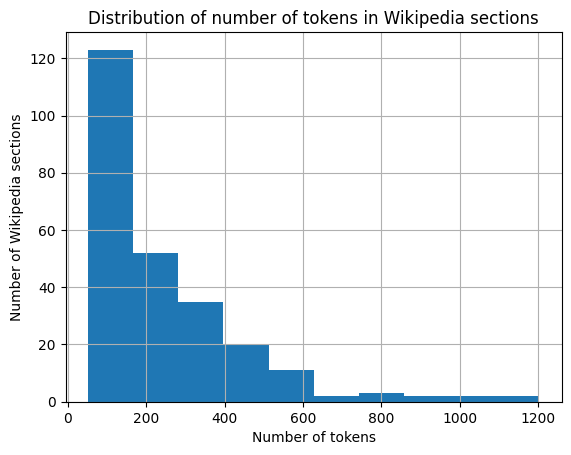

In [8]:
df = pd.read_csv('wc_sections.csv')
df[['tokens']].hist()
# add axis descriptions and title
plt.xlabel('Number of tokens')
plt.ylabel('Number of Wikipedia sections')
plt.title('Distribution of number of tokens in Wikipedia sections')
plt.show()